## ToDo:

- is the central discontinuity a statisitcal problem?
- is it an implementation problem?

## Statistics with Actual Implementation

40.37267080745342 %


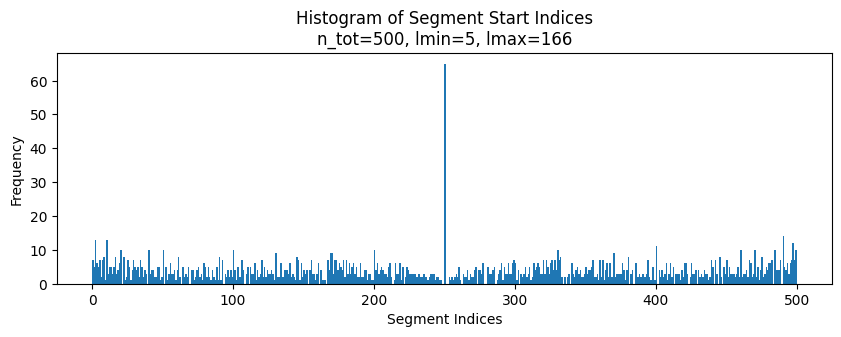

In [14]:
import numpy as np
import matplotlib.pyplot as plt

n_tot = 500
lmin = 5
lmax = n_tot // 3

n_l = lmax - lmin
counter = 0
sample = []
for length in range(lmin, lmax + 1):
    # Note: numba-compatible version of centered_segmentation (deprecated)
    n_seg = int(n_tot / length)  # number of segments
    rest = n_tot - n_seg * length  # uncovered points
    idx0 = int(rest / 2)  # first index of the first segment
    seg_idces = idx0 + length * np.arange(n_seg + 1)  # first index of each segment
    for idx in seg_idces:
        sample.append(int(idx) )#- (n_tot // 2))

    #print(f"Segment indices for length {length}: {seg_idces}")
    if (n_tot // 2) in seg_idces:
        counter += 1

print(f"{counter/n_l*100} %")
#print(sample)

# histogram
plt.figure(figsize=(10, 3))
plt.hist(sample, bins=n_tot)
plt.xlabel("Segment Indices")
plt.ylabel("Frequency")
plt.title(f"Histogram of Segment Start Indices\nn_tot=500, lmin={int(lmin)}, lmax={int(lmax)}")
plt.show()

## Statistics using My Own Formulas

In [60]:
import numpy as np

def ix0(n_tot, length):
    return int((n_tot%length) / 2)

def ix0_max(n_tot, length):

    n_seg = int(n_tot / length)     # number of segments
    res = n_tot - n_seg * length    # uncovered points
    return res                      # truncate the whole beginning

def ix0_anti(n_tot, length):
    """
    Align center of ts with center of segment.
    """

    ix_center_ts = int(n_tot / 2)
    ix_center_seg = int(length / 2)
    idx_center = ix_center_ts - ix_center_seg
    idx0 = idx_center%length

    return idx0

def ix0_picked(n_tot, length):

    n_seg = int(n_tot / length)     # number of segments
    rest = n_tot - n_seg * length   # uncovered points
    idx0 = int(rest / 2)            # first index of the first segment

    if idx0 == ix0_center(n_tot, length):
        idx0 += np.random.randint(length//2)

    return idx0

def ix0_center(n_tot, length):
    return int(n_tot/2)%length

def ix0_offset(n_tot, length, offset):
    return (int(n_tot/2) + offset) % length

lmin = 5

n_arr = np.arange(lmin*3, 200)
match_count = 0
total_count = 0
for n_tot in n_arr:
    #print(n_tot)
    lmax = n_tot // 3
    for length in range(lmin, lmax + 1):
        #print(length)
        if ix0(n_tot, length) == ix0_center(n_tot, length):
            match_count += 1
        total_count += 1

print(f"{match_count / total_count * 100} %")

40.83146455062964 %


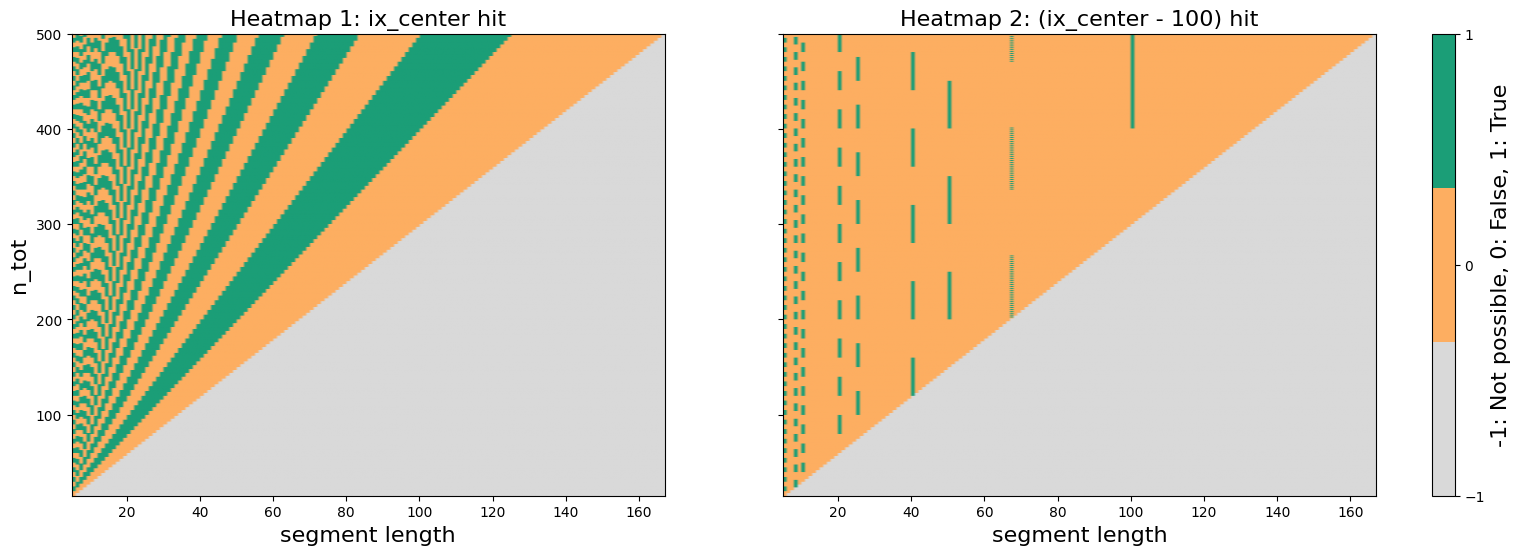

In [4]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

lmin = 5
n_arr = np.arange(lmin*3, 500)
offset = 100

# Prepare the heatmap array
heatmap1 = np.full((len(n_arr), n_arr[-1]//3 + 1-lmin), -1)  # -1: not possible, 0: red, 1: green
heatmap2 = np.full((len(n_arr), n_arr[-1]//3 + 1-lmin), -1)  # -1: not possible, 0: red, 1: green

for i, n_tot in enumerate(n_arr):
    lmax = n_tot // 3
    for length in range(lmin, lmax + 1):
        if ix0(n_tot, length) == (ix0_center(n_tot, length)):
            heatmap1[i, length-lmin] = 1  # green
        else:
            heatmap1[i, length-lmin] = 0  # red

        if ix0(n_tot, length) == (ix0_offset(n_tot, length, offset)):
            heatmap2[i, length-lmin] = 1  # green
        else:
            heatmap2[i, length-lmin] = 0  # red

# Create a custom colormap: -1 (black), 0 (red), 1 (green)
cmap = ListedColormap(
    ['#d9d9d9',  # light gray
     '#fdae61',  # soft orange
     '#1b9e77']  # teal/greenish-blue
     , [-1,0,1]
     )

fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

im1 = axes[0].imshow(
    heatmap1,
    aspect='auto',
    cmap=cmap,
    origin='lower',
    extent=[lmin, heatmap1.shape[1] + lmin, n_arr[0], n_arr[-1] + 1],
    vmin=-1, vmax=1
)
axes[0].set_xlabel('segment length', fontsize=16)
axes[0].set_ylabel('n_tot', fontsize=16)
axes[0].set_title('Heatmap 1: ix_center hit', fontsize=16)

im2 = axes[1].imshow(
    heatmap2,
    aspect='auto',
    cmap=cmap,
    origin='lower',
    extent=[lmin, heatmap2.shape[1] + lmin, n_arr[0], n_arr[-1] + 1],
    vmin=-1, vmax=1
)
axes[1].set_xlabel('segment length', fontsize=16)
axes[1].set_title(f'Heatmap 2: (ix_center - {offset}) hit', fontsize=16)

# Create a single colorbar for both plots
cbar = fig.colorbar(im1, ax=axes, orientation='vertical', fraction=0.025, pad=0.04, ticks=[-1, 0, 1])
cbar.set_label('-1: Not possible, 0: False, 1: True', fontsize=16)

#plt.tight_layout()
plt.show()

shape.heatmap1: (500, 500)


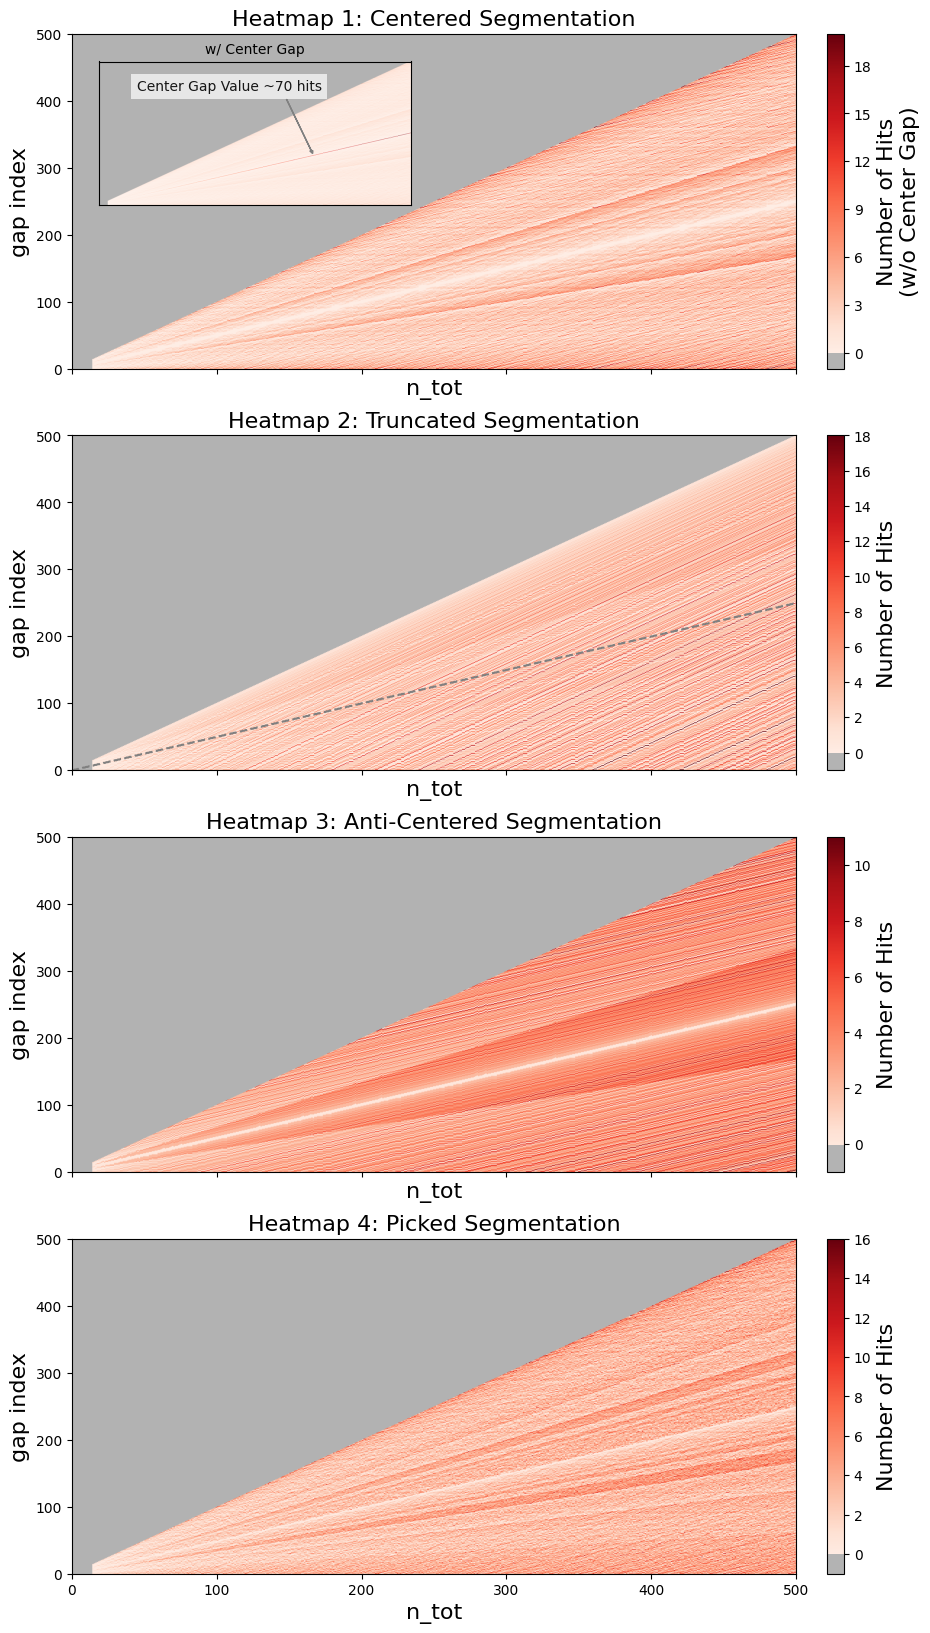

In [61]:
from matplotlib.colors import ListedColormap
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from toad.shifts.methods.asdetect_new import centered_segmentation, truncated_segmentation, anti_centered_segmentation
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

lmin = 5
n_max = 500
n_arr = np.arange(lmin*3, n_max+1)

# Prepare the heatmap array
heatmap1 = np.full((n_max, n_max), -1)
heatmap11 = np.full((n_max, n_max), -1)
heatmap2 = np.full((n_max, n_max), -1)
heatmap3 = np.full((n_max, n_max), -1)
heatmap4 = np.full((n_max, n_max), -1)

print(f"shape.heatmap1: {heatmap1.shape}")
for i, n_tot in enumerate(n_arr):
    lmax = n_tot // 3
    heatmap1[:n_tot, n_tot-1] += 1      # level from -1 to 0 to indicate that this combination is used
    heatmap11[:n_tot, n_tot-1] += 1     # this one is used to track with removed center gap
    heatmap2[:n_tot, n_tot-1] += 1
    heatmap3[:n_tot, n_tot-1] += 1
    heatmap4[:n_tot, n_tot-1] += 1

    sample1 = []
    sample11 = []
    sample2 = []
    sample3 = []
    sample4 = []
    for length in range(lmin, lmax + 1):

        # use different indexing methods to determine the first starting index
        idx1 = ix0(n_tot, length)
        idx2 = ix0_max(n_tot, length)
        idx3 = ix0_anti(n_tot, length)
        idx4 = ix0_picked(n_tot, length)

        n_seg = int(n_tot / length)     # number of segments
        seg_idces1 = idx1 + length * np.arange(n_seg + 1)    # first index of each segment
        seg_idces1 = seg_idces1[seg_idces1 < n_tot]
        seg_idces11 = seg_idces1[seg_idces1 != n_tot//2]
        seg_idces2 = idx2 + length * np.arange(n_seg + 1)    # first index of each segment
        seg_idces2 = seg_idces2[seg_idces2< n_tot]
        seg_idces3 = idx3 + length * np.arange(n_seg + 1)    # first index of each segment
        seg_idces3 = seg_idces3[seg_idces3< n_tot]
        seg_idces4 = idx4 + length * np.arange(n_seg + 1)    # first index of each segment
        seg_idces4 = seg_idces4[seg_idces4< n_tot]

        for idx in seg_idces1:
            sample1.append(int(idx))
        for idx in seg_idces11:
            sample11.append(int(idx))
        for idx in seg_idces2:
            sample2.append(int(idx))
        for idx in seg_idces3:
            sample3.append(int(idx))
        for idx in seg_idces4:
            sample4.append(int(idx))

    hist1, _ = np.histogram(sample1, bins=n_tot)
    hist11, _ = np.histogram(sample11, bins=n_tot)
    hist2, _ = np.histogram(sample2, bins=n_tot)
    hist3, _ = np.histogram(sample3, bins=n_tot)
    hist4, _ = np.histogram(sample4, bins=n_tot)

    heatmap1[:n_tot, n_tot-1] += hist1
    heatmap11[:n_tot, n_tot-1] += hist11
    heatmap2[:n_tot, n_tot-1] += hist2
    heatmap3[:n_tot, n_tot-1] += hist3
    heatmap4[:n_tot, n_tot-1] += hist4

cmap_reds = matplotlib.colormaps['Reds']
newcolors = cmap_reds(np.linspace(0, 1, 256))
grey = np.array([0.7, 0.7, 0.7, 1])

fig, axes = plt.subplots(4, 1, figsize=(10, 20), sharex=True)

# PLOT: ================================================================================

ix11 = 256//(heatmap11.max()+1)
newcolors11 = np.copy(newcolors)
newcolors11[:ix11, :] = grey
cmap_custom11 = ListedColormap(newcolors11)

# Main plot for heatmap11 (center gap removed)
im11 = axes[0].imshow(
    heatmap11,
    aspect='auto',
    cmap=cmap_custom11,
    origin='lower',
    extent=[0, n_max, 0, n_max],
    vmin=-1, vmax=None,
)
axes[0].set_xlabel('n_tot', fontsize=16)
axes[0].set_ylabel('gap index', fontsize=16)
axes[0].set_title('Heatmap 1: Centered Segmentation', fontsize=16)

# Create a colorbar for the first heatmap
cbar11 = fig.colorbar(im11, ax=axes[0], orientation='vertical', fraction=0.025, pad=0.04)
cbar11.set_label('Number of Hits\n(w/o Center Gap)', fontsize=16)
cbar11.ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

# Inset: show heatmap1 in the top left corner of axes[0]
ix1 = 256//(heatmap1.max()+1)
newcolors1 = np.copy(newcolors)
newcolors1[:ix1, :] = grey
cmap_custom1 = ListedColormap(newcolors1)

axins = inset_axes(axes[0], width="43%", height="43%", loc='upper left', borderpad=2)
im1 = axins.imshow(
    heatmap1,
    aspect='auto',
    cmap=cmap_custom1,
    origin='lower',
    extent=[0, n_max, 0, n_max],
    vmin=-1, vmax=None,
)
axins.set_xticks([])
axins.set_yticks([])
axins.set_title("w/ Center Gap", fontsize=10)

axins.text(
    60, 400,  # x, y coordinates in data units
    "Center Gap Value ~70 hits",
    fontsize=10,
    color='black',
    alpha=0.9,
    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
)
axins.arrow(300, 370, 40, -180, head_width=5, head_length=10, fc='grey', ec='grey')

# PLOT: ================================================================================

ix2 = 256//(heatmap2.max()+1)
newcolors2 = np.copy(newcolors)
newcolors2[:ix2, :] = grey
cmap_custom2 = ListedColormap(newcolors2)

im2 = axes[1].imshow(
    heatmap2,
    aspect='auto',
    cmap=cmap_custom2,
    origin='lower',
    extent=[0, n_max, 0, n_max],
    vmin=-1, vmax=None,
)
axes[1].plot(np.arange(n_max), np.arange(n_max)//2, color='grey', linestyle='--')
axes[1].set_xlabel('n_tot', fontsize=16)
axes[1].set_ylabel('gap index', fontsize=16)
axes[1].set_title(f'Heatmap 2: Truncated Segmentation', fontsize=16)

# Create a colorbar for the second heatmap
cbar2 = fig.colorbar(im2, ax=axes[1], orientation='vertical', fraction=0.025, pad=0.04)
cbar2.set_label('Number of Hits', fontsize=16)
cbar2.ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

# PLOT: ================================================================================

ix3 = 256//(heatmap3.max()+1)
newcolors3 = np.copy(newcolors)
newcolors3[:ix3, :] = grey
cmap_custom3 = ListedColormap(newcolors3)

im3 = axes[2].imshow(
    heatmap3,
    aspect='auto',
    cmap=cmap_custom3,
    origin='lower',
    extent=[0, n_max, 0, n_max],
    vmin=-1, vmax=None,
)
axes[2].set_xlabel('n_tot', fontsize=16)
axes[2].set_ylabel('gap index', fontsize=16)
axes[2].set_title(f'Heatmap 3: Anti-Centered Segmentation', fontsize=16)

# Create a colorbar for the third heatmap
cbar3 = fig.colorbar(im3, ax=axes[2], orientation='vertical', fraction=0.025, pad=0.04)
cbar3.set_label('Number of Hits', fontsize=16)

# PLOT: ================================================================================

ix4 = 256//(heatmap4.max()+1)
newcolors4 = np.copy(newcolors)
newcolors4[:ix4, :] = grey
cmap_custom4 = ListedColormap(newcolors4)

im4 = axes[3].imshow(
    heatmap4,
    aspect='auto',
    cmap=cmap_custom4,
    origin='lower',
    extent=[0, n_max, 0, n_max],
    vmin=-1, vmax=None,
)
axes[3].set_xlabel('n_tot', fontsize=16)
axes[3].set_ylabel('gap index', fontsize=16)
axes[3].set_title(f'Heatmap 4: Picked Segmentation', fontsize=16)

# Create a colorbar for the fourth heatmap
cbar4 = fig.colorbar(im4, ax=axes[3], orientation='vertical', fraction=0.025, pad=0.04)
cbar4.set_label('Number of Hits', fontsize=16)

plt.show()

## Finding better Segmentations

My first idea is to brute force the uniformness of the final gap probability distribution by shifting the starting index for every value of segment length so minimizie the un-uniformness. Hence, we need a measure which quantifies how uniform the current distribution is, so we can choose the one starting index with the least deviation.

Asking ChatGPT about a measure which is sensitive to outliers, it came up with the following suggestions. $u(i)$ represents the target distribution (here: uniform):

- Kullback–Leibler Divergence (KL divergence) from Uniform

$$ D_{KL}​(p∥u)=∑_i​p(i)log \left( \frac{p(i)}{u(i)} \right)​ $$

- Chi-Square Distance from Uniform

$$ χ^2=∑_i​ \frac{(p(i)−u(i))^2}{u(i)}​ $$

- Shannon-Entropy Deficit

$$ H(p)=−∑_i​p(i)logp(i) $$
$$ \rightarrow \text{Deficit: }  ΔH=log \left( n \right) − H(p) $$

- Gini Coefficient (Inequality of Probabilities)

$$ G =  \frac{∑_{i=1}^{n} ​∑_{j=1}^{n} ​∣p(i)−p(j)∣}{2n ∑_{i=1}^{n} ​p(i)}​ $$
    -> G=0 means uniform

- Outlier-Sensitive Max/Mean Ratio

$$ R = \frac{max_i ​p(i)}{mean(p(i))} $$

In [4]:
# measures for uniformity

import numpy as np

def homogeneity_measures(hist):
    """
    Compute several measures of homogeneity / uniformity for a probability distribution.
    
    Parameters
    ----------
    hist : array-like
        Histogram values (counts or probabilities). Will be normalized internally.
    
    Returns
    -------
    dict
        Dictionary of homogeneity measures.
    """
    hist = np.asarray(hist, dtype=float)
    if hist.sum() <= 0:
        raise ValueError("Histogram must have positive total count.")
        
    # Normalize to probability distribution
    p = hist / hist.sum()
    n = len(p)
    uniform = np.ones(n) / n
    
    # --- 1. KL Divergence from uniform ---
    # Avoid log(0) by masking zeros
    mask = p > 0
    kl_div = np.sum(p[mask] * np.log(p[mask] / uniform[mask]))
    
    # --- 2. Chi-Square distance from uniform ---
    chi2 = np.sum((p - uniform) ** 2 / uniform)
    
    # --- 3. Entropy deficit ---
    entropy = -np.sum(p[mask] * np.log(p[mask]))
    max_entropy = np.log(n)
    entropy_deficit = max_entropy - entropy
    
    # --- 4. Gini coefficient ---
    # Equivalent to inequality measure of p
    diff_sum = np.sum(np.abs(p[:, None] - p[None, :]))
    gini = diff_sum / (2 * n * p.sum())
    
    # --- 5. Max/mean ratio ---
    mean_prob = np.mean(p)
    max_mean_ratio = np.max(p) / mean_prob
    
    return {
        "KL_divergence": kl_div,
        "Chi2_distance": chi2,
        "Entropy_deficit": entropy_deficit,
        "Gini_coefficient": gini,
        "Max_mean_ratio": max_mean_ratio,
    }


# Perfectly uniform histogram of 10 bins
uniform_hist = np.ones(10)
print("Uniform histogram:", homogeneity_measures(uniform_hist))

# Histogram with one big outlier
outlier_hist = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 50])
print("\nOutlier histogram:", homogeneity_measures(outlier_hist))


Uniform histogram: {'KL_divergence': np.float64(0.0), 'Chi2_distance': np.float64(0.0), 'Entropy_deficit': np.float64(4.440892098500626e-16), 'Gini_coefficient': np.float64(0.0), 'Max_mean_ratio': np.float64(1.0)}

Outlier histogram: {'KL_divergence': np.float64(1.540321382502009), 'Chi2_distance': np.float64(6.207698937087043), 'Entropy_deficit': np.float64(1.5403213825020095), 'Gini_coefficient': np.float64(0.7474576271186442), 'Max_mean_ratio': np.float64(8.47457627118644)}


In [5]:
# function to create histogram
import numpy as np

def agg_idx0(n_tot, lmin=5, lmax=None):

    if lmax is None:
        lmax = n_tot // 3

    sample = []
    for length in range(lmin, lmax + 1):
        n_seg = int(n_tot / length)                         # number of segments
        rest = n_tot - n_seg * length                       # uncovered points
        idx0 = int(rest / 2)                                # first index of the first segment
        seg_idces = idx0 + length * np.arange(n_seg + 1)    # first index of each segment
        for idx in seg_idces:
            sample.append(int(idx))

    return sample

In [6]:
n_tot = 500
sample = agg_idx0(n_tot)

# make a histogram-array
hist, bin_edges = np.histogram(sample, bins=n_tot)

homogeneity_measures(hist)

{'KL_divergence': np.float64(0.29133077103036126),
 'Chi2_distance': np.float64(0.9343096553069403),
 'Entropy_deficit': np.float64(0.29133077103036165),
 'Gini_coefficient': np.float64(0.3802144743792921),
 'Max_mean_ratio': np.float64(17.16851558372953)}

In [7]:
import numpy as np

def KL(hist):
    hist = np.asarray(hist, dtype=float)
    
    # Normalize to probability distribution
    p = hist / hist.sum()
    n = len(p)
    uniform = np.ones(n) / n

    # Avoid log(0) by masking zeros
    mask = p > 0
    kl_div = np.sum(p[mask] * np.log(p[mask] / uniform[mask]))

    return kl_div


def chi2(hist):
    hist = np.asarray(hist, dtype=float)
    
    # Normalize to probability distribution
    p = hist / hist.sum()
    n = len(p)
    uniform = np.ones(n) / n
    
    return np.sum((p - uniform) ** 2 / uniform)

def entropy(hist):
    hist = np.asarray(hist, dtype=float)
    
    # Normalize to probability distribution
    p = hist / hist.sum()
    n = len(p)

    # --- Entropy deficit ---
    # Avoid log(0) by masking zeros
    mask = p > 0
    entropy = -np.sum(p[mask] * np.log(p[mask]))
    max_entropy = np.log(n)
    entropy_deficit = max_entropy - entropy

    return entropy_deficit

def max_mean(hist):
    hist = np.asarray(hist, dtype=float)

    # Normalize to probability distribution
    p = hist / hist.sum()

    # --- Max/mean ratio ---
    mean_prob = np.mean(p)
    max_mean_ratio = np.max(p) / mean_prob

    return max_mean_ratio

In [ ]:
# segmentation with adapting starting index
import numpy as np

def adapting_idx0(n_tot,
                  ufunc,
                  lmin=5,
                  lmax=None,
                  verbose=False):
    """
    This function computes the maximum possible number of segments
    and how many points will be uncovered. Within this range of uncovered
    points, the function runs through all possible starting indices and finds
    the one which leads to the most uniform distribution of gap indices.
    """

    if lmax is None:
        lmax = n_tot // 3

    sample = []
    for length in range(lmin, lmax + 1):
        n_seg = int(n_tot / length)                         # number of segments
        rest = n_tot - n_seg * length                       # uncovered points
        if verbose: print(f"Length: {length}, Segments: {n_seg}, Uncovered: {rest}")
        if rest != 0:
            q_arr = []
            for idx0 in range(rest + 1):                     # try all possible starting indices for the first segment
                seg_idces = idx0 + length * np.arange(n_seg + 1)
                q_arr.append(ufunc(seg_idces))
            
            if verbose: print(q_arr)
            idx0 = np.argmin(q_arr)  # choose the starting index which leads to the most uniform distribution
        else:
            idx0 = 0
        if verbose: print(f"Minimizing Starting Index: {idx0}")
        seg_idces = idx0 + length * np.arange(n_seg + 1)    # first index of each segment
        for idx in seg_idces:
            sample.append(int(idx))

    return sample


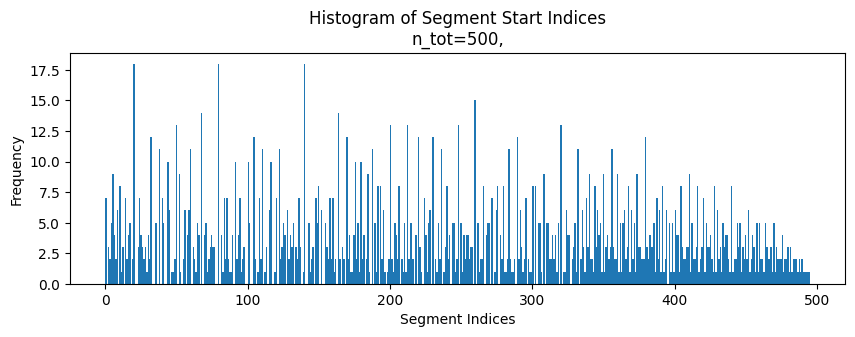

In [17]:
import matplotlib.pyplot as plt

n_tot = 500
sample = adapting_idx0(n_tot,
                       KL,
                       #verbose=True,
                       )
# filter out n_tot
sample = [s for s in sample if s < n_tot]

# histogram
plt.figure(figsize=(10, 3))
plt.hist(sample, bins=n_tot)
plt.xlabel("Segment Indices")
plt.ylabel("Frequency")
plt.title(f"Histogram of Segment Start Indices\nn_tot=500,")
plt.show()

## Truncate the Whole Start

In [ ]:
import numpy as np

def max_idx0(n_tot,
                  lmin=5,
                  lmax=None,
                  verbose=False):
    """
    """

    if lmax is None:
        lmax = n_tot // 3

    sample = []
    for length in range(lmin, lmax + 1):
        n_seg = int(n_tot / length)                         # number of segments
        rest = n_tot - n_seg * length                       # uncovered points
        idx0 = rest
        if verbose: print(f"Minimizing Starting Index: {idx0}")
        seg_idces = idx0 + length * np.arange(n_seg + 1)    # first index of each segment
        for idx in seg_idces:
            sample.append(int(idx))

    return sample


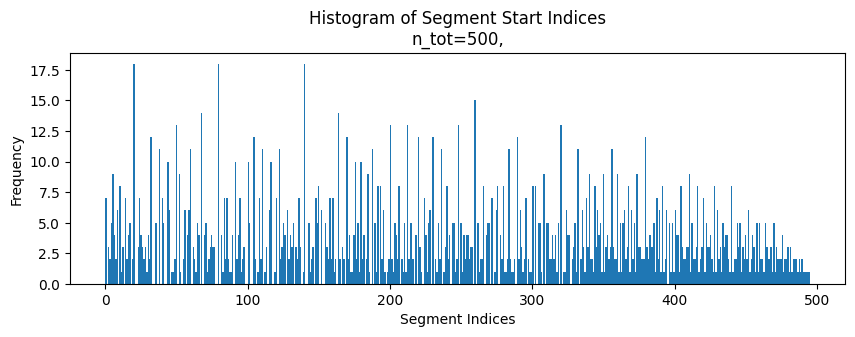

In [58]:
import matplotlib.pyplot as plt

n_tot = 500
sample = max_idx0(n_tot,
                       #verbose=True,
                       )
# filter out n_tot
sample = [s for s in sample if s < n_tot]

# histogram
plt.figure(figsize=(10, 3))
plt.hist(sample, bins=n_tot)
plt.xlabel("Segment Indices")
plt.ylabel("Frequency")
plt.title(f"Histogram of Segment Start Indices\nn_tot=500,")
plt.show()

## Align the Center of a Segment with the Center of the Time Series

Make sure that the center of the time series is at the center of a segment. This might lead to more truncations at the ends.

In [ ]:
import numpy as np

def anti_center_idx0(n_tot,
                    lmin=5,
                    lmax=None,
                    verbose=False):
    """
    """

    if lmax is None:
        lmax = n_tot // 3

    sample = []
    for length in range(lmin, lmax + 1):
        ix_center_ts = int(n_tot / 2)
        ix_center_seg = int(length / 2)
        idx_center = ix_center_ts - ix_center_seg
        idx0 = idx_center%length
        n_seg = int(n_tot / length)                         # number of segments
        #rest = n_tot - n_seg * length                       # uncovered points
        #idx0 = rest
        if verbose: print(f"Starting Index: {idx0}")
        seg_idces = idx0 + length * np.arange(n_seg + 1)    # first index of each segment
        seg_idces = seg_idces[seg_idces < n_tot]
        for idx in seg_idces:
            sample.append(int(idx))

    return sample


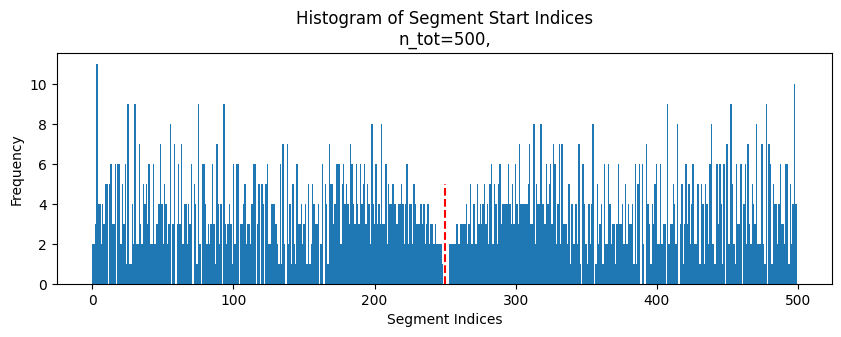

In [3]:
import matplotlib.pyplot as plt

n_tot = 500
sample = anti_center_idx0(n_tot,
                          #verbose=True,
                          )
# filter out n_tot
sample = [s for s in sample if s < n_tot]

# histogram
plt.figure(figsize=(10, 3))
plt.hist(sample, bins=n_tot)
plt.vlines(n_tot//2, 0, 5, colors='r', linestyles='dashed')
plt.xlabel("Segment Indices")
plt.ylabel("Frequency")
plt.title(f"Histogram of Segment Start Indices\nn_tot=500,")
plt.show()

## Only offset the ones aligning with the center

In [81]:

import numpy as np

def ix0_center(n_tot, length):
    return int(n_tot/2)%length


def picked_offset_idx0(n_tot,
                lmin=5,
                lmax=None,
                verbose=False):
    """
    """

    if lmax is None:
        lmax = n_tot // 3

    sample = []
    for length in range(lmin, lmax + 1):

        n_seg = int(n_tot / length)     # number of segments
        rest = n_tot - n_seg * length   # uncovered points
        idx0 = int(rest / 2)            # first index of the first segment

        if idx0 == ix0_center(n_tot, length):
            idx0 += np.random.randint(length//2)

        if verbose: print(f"Starting Index: {idx0}")
        seg_idces = idx0 + length * np.arange(n_seg + 1)    # first index of each segment
        seg_idces = seg_idces[seg_idces < n_tot]
        for idx in seg_idces:
            sample.append(int(idx))

    return sample


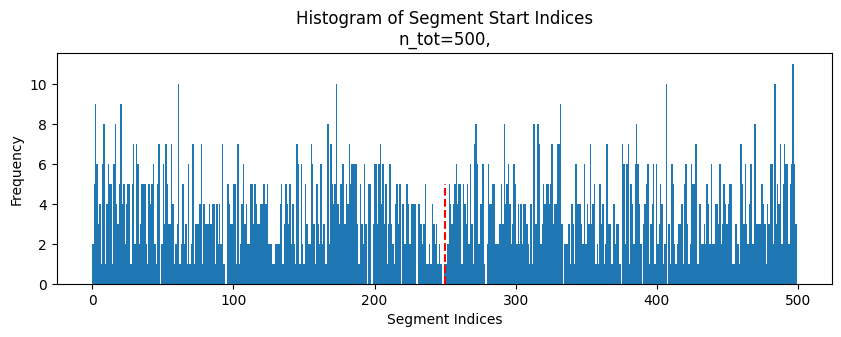

In [82]:
import matplotlib.pyplot as plt

n_tot = 500
sample = picked_offset_idx0(n_tot,
                          #verbose=True,
                          )
# filter out n_tot
sample = [s for s in sample if s < n_tot]

# histogram
plt.figure(figsize=(10, 3))
plt.hist(sample, bins=n_tot)
plt.vlines(n_tot//2, 0, 5, colors='r', linestyles='dashed')
plt.xlabel("Segment Indices")
plt.ylabel("Frequency")
plt.title(f"Histogram of Segment Start Indices\nn_tot=500,")
plt.show()

## Centered Segmentation with alternating floor/ceiling division

In [ ]:
import numpy as np

def alternate_idx0(n_tot,
                    lmin=5,
                    lmax=None,
                    verbose=False):
    """
    """

    if lmax is None:
        lmax = n_tot // 3

    sample = []
    offset = 0
    for length in range(lmin, lmax + 1):

        if verbose: print(f"offset: {offset}")
        n_seg = int(n_tot / length)     # number of segments
        rest = n_tot - n_seg * length   # uncovered points
        idx0 = int(rest / 2) + offset   # first index of the first segment
        offset += 1
        offset %= 2

        if verbose: print(f"Starting Index: {idx0}")
        seg_idces = idx0 + length * np.arange(n_seg + 1)    # first index of each segment
        seg_idces = seg_idces[seg_idces < n_tot]
        for idx in seg_idces:
            sample.append(int(idx))

    return sample


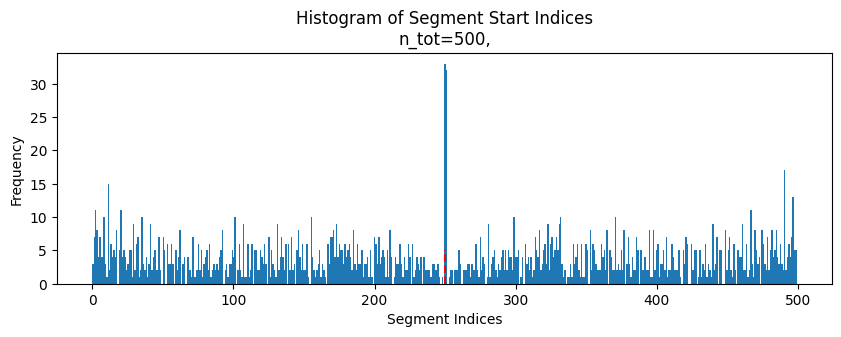

In [54]:
import matplotlib.pyplot as plt

n_tot = 500
sample = alternate_idx0(n_tot,
                        #verbose=True,
                        )
# filter out n_tot
sample = [s for s in sample if s < n_tot]

# histogram
plt.figure(figsize=(10, 3))
plt.hist(sample, bins=n_tot)
plt.vlines(n_tot//2, 0, 5, colors='r', linestyles='dashed')
plt.xlabel("Segment Indices")
plt.ylabel("Frequency")
plt.title(f"Histogram of Segment Start Indices\nn_tot=500,")
plt.show()

## Making an ASDETECT version with this

/home/lukasro/Documents/TIPMIP/toad/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


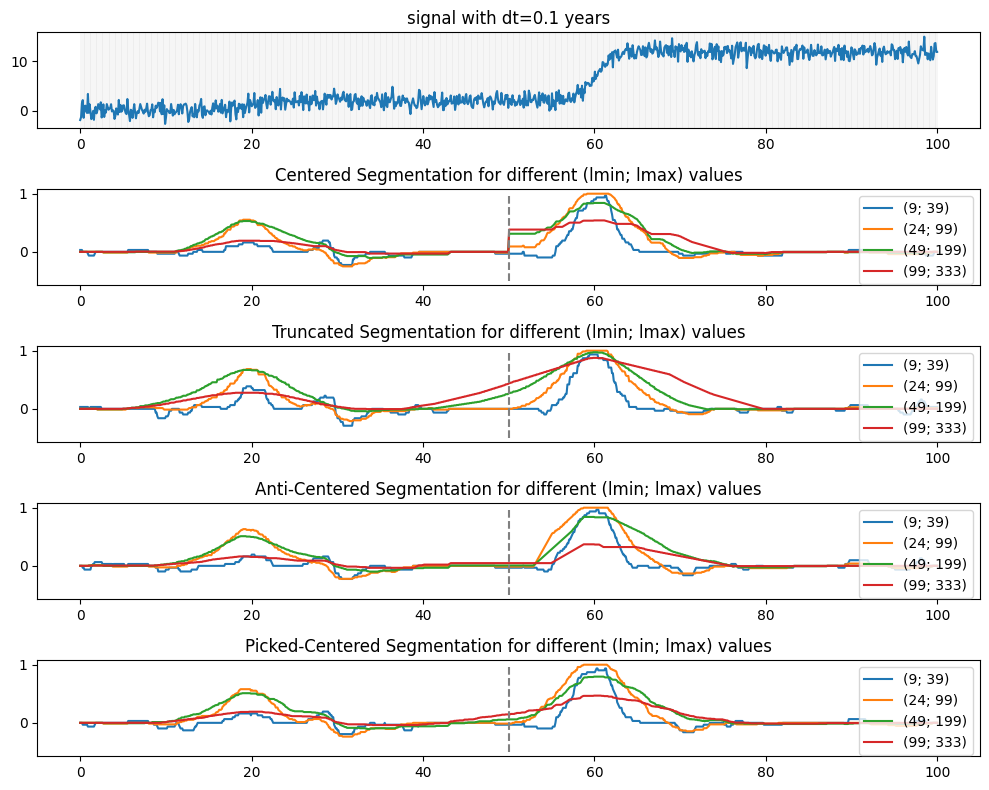

In [1]:
import toad 
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt

from toad.shifts.methods.asdetect_new import ASDETECT as ASDETECT_new
from toad.shifts.methods.asdetect_new import centered_segmentation, dynamic_segmentation, truncated_segmentation, anti_centered_segmentation, picked_centered_segmentation


def shift(mag, t, t0):
    return mag * (1/(1 + np.exp(-(t-t0))))

# Do the following for two different time resolutions to show that lmin, lmax 
# are inferred/adapted correctly 
 
dt = 0.1
Tmax = 100 # years
nT = int(Tmax/dt) # number of gridpoints in time

# SIGNAL GENERATION =======================================================
noise = np.random.normal(size=nT)
time = np.linspace(0,Tmax, nT)

signal = (noise 
            + shift(10, time, 60)
            + shift(2,time,20)   
        )

# PLOT: SIGNAL ============================================================
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(ncols=1, nrows=5)
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(time, signal)
for t in time:
    ax1.axvline(t, color='grey', alpha=0.1, lw=0.5, zorder=-1)
ax1.set_title(f'signal with dt={dt} years')

# PLOT: CENTERED SEGMENTATION ==========================
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
for lmin, lmax in [(9,39),(24,99),(49,199),(99,333)]:
    detector = ASDETECT_new(
        lmin=lmin,
        lmax=lmax,)
    dts = detector.fit_predict(
        signal,
        time,
        ufunc=centered_segmentation
        )

    ax2.plot(time, dts, label=f'({lmin}; {lmax})')
ax2.vlines(x=Tmax//2, ymin=-0.5, ymax=1, color='grey', linestyles='--')
ax2.set_title('Centered Segmentation for different (lmin; lmax) values')
ax2.legend()

# PLOT: TRUNCATED SEGMENTATION ==========================
ax3 = fig.add_subplot(gs[2, 0], sharex=ax1)
for lmin, lmax in [(9,39),(24,99),(49,199),(99,333)]:
    detector = ASDETECT_new(
        lmin=lmin,
        lmax=lmax,)
    dts = detector.fit_predict(
        signal,
        time,
        ufunc=truncated_segmentation
        )

    ax3.plot(time, dts, label=f'({lmin}; {lmax})')
ax3.vlines(x=Tmax//2, ymin=-0.5, ymax=1, color='grey', linestyles='--')
ax3.set_title('Truncated Segmentation for different (lmin; lmax) values')
ax3.legend()


# PLOT: ANTI-CENTERED SEGMENTATION ==========================
ax4 = fig.add_subplot(gs[3, 0], sharex=ax1)
for lmin, lmax in [(9,39),(24,99),(49,199),(99,333)]:
    detector = ASDETECT_new(
        lmin=lmin,
        lmax=lmax,)
    dts = detector.fit_predict(
        signal,
        time,
        ufunc=anti_centered_segmentation
        )

    ax4.plot(time, dts, label=f'({lmin}; {lmax})')
ax4.vlines(x=Tmax//2, ymin=-0.5, ymax=1, color='grey', linestyles='--')
ax4.set_title('Anti-Centered Segmentation for different (lmin; lmax) values')
ax4.legend()


# PLOT: PICKED-CENTERED SEGMENTATION ==========================
ax5 = fig.add_subplot(gs[4, 0], sharex=ax1)
for lmin, lmax in [(9,39),(24,99),(49,199),(99,333)]:
    detector = ASDETECT_new(
        lmin=lmin,
        lmax=lmax,)
    dts = detector.fit_predict(
        signal,
        time,
        ufunc=picked_centered_segmentation
        )

    ax5.plot(time, dts, label=f'({lmin}; {lmax})')
ax5.vlines(x=Tmax//2, ymin=-0.5, ymax=1, color='grey', linestyles='--')
ax5.set_title('Picked-Centered Segmentation for different (lmin; lmax) values')
ax5.legend()


plt.tight_layout()
plt.show()

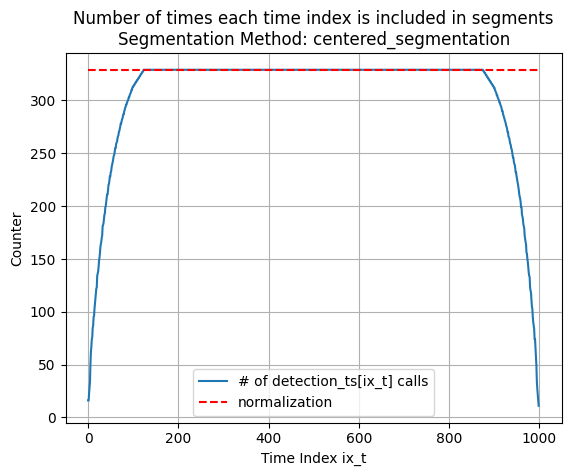

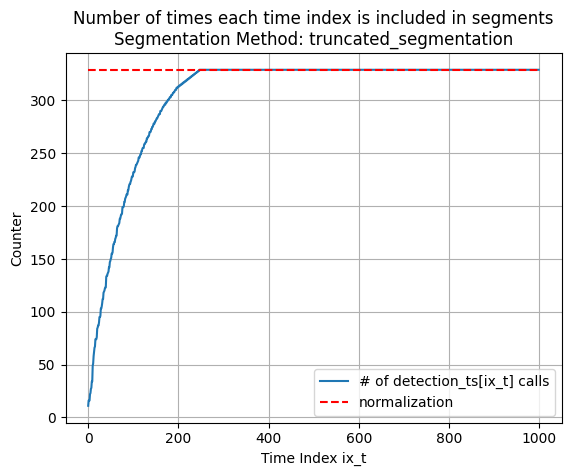

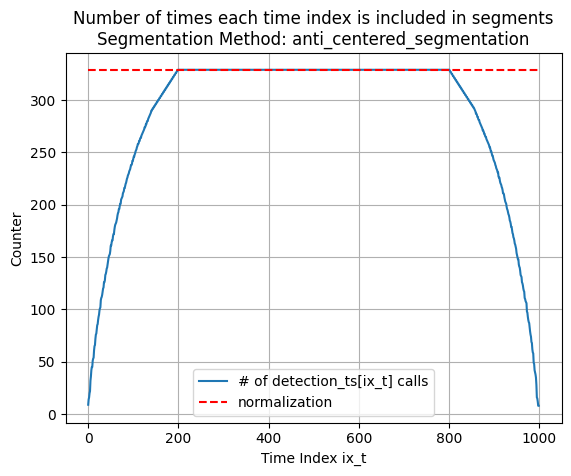

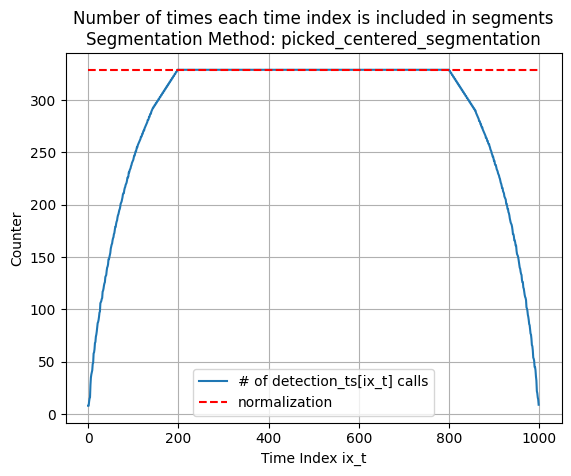

In [2]:
import toad 
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt

from toad.shifts.methods.asdetect_new import ASDETECT as ASDETECT_new
from toad.shifts.methods.asdetect_new import centered_segmentation, dynamic_segmentation, truncated_segmentation, anti_centered_segmentation, picked_centered_segmentation


def shift(mag, t, t0):
    return mag * (1/(1 + np.exp(-(t-t0))))

# Do the following for two different time resolutions to show that lmin, lmax 
# are inferred/adapted correctly 
 
dt = 0.1
Tmax = 100 # years
nT = int(Tmax/dt) # number of gridpoints in time

# SIGNAL GENERATION =======================================================
noise = np.random.normal(size=nT)
time = np.linspace(0,Tmax, nT)

signal = (noise 
            + shift(10, time, 60)
            + shift(2,time,20)   
        )

# PLOT: CENTERED SEGMENTATION ==========================

detector = ASDETECT_new()
dts = detector.fit_predict(
    signal,
    time,
    ufunc=centered_segmentation,
    counter_plot=True,
    )

# PLOT: TRUNCATED SEGMENTATION ==========================

detector = ASDETECT_new()
dts = detector.fit_predict(
    signal,
    time,
    ufunc=truncated_segmentation,
    counter_plot=True,
    )


# PLOT: ANTI-CENTERED SEGMENTATION ==========================

detector = ASDETECT_new()
dts = detector.fit_predict(
    signal,
    time,
    ufunc=anti_centered_segmentation,
    counter_plot=True,
    )


# PLOT: PICKED-CENTERED SEGMENTATION ==========================

detector = ASDETECT_new()
dts = detector.fit_predict(
    signal,
    time,
    ufunc=picked_centered_segmentation,
    counter_plot=True,
    )


In [48]:
import numpy as np
import matplotlib.pyplot as plt

def center_hit(n_tot, length):
    # centered segmentation first starting index
    ix0 = int((n_tot - int(n_tot/length)*length)//2)

    # center hit index
    ix_center = int(n_tot/2)%length

    return ix0 == ix_center

def evenly_divisible(n_tot, length):
    return (n_tot//length)%2 == 0

In [53]:
n_max = 10000
lmin = 5

for n_tot in range(lmin*3, n_max+1):
    lmax = n_tot // 3
    chit_arr = []
    even_arr = []
    for l in range(lmin, lmax + 1):
        if center_hit(n_tot, l):
            chit_arr.append(l)
        if evenly_divisible(n_tot, l):
            even_arr.append(l)
 
    # overlap of both sets
    overlap = sorted(list(set(even_arr).intersection(set(chit_arr))))

    if len(overlap) != len(chit_arr) or len(overlap) != len(even_arr):
        print(f"n_tot: {n_tot}")
        print(f"center hit numbers: {chit_arr}")
        print(f"evenly divisible numbers: {even_arr}")
        print(f"Overlap of both sets:\t\t{overlap}\n")
        break
    else:
        pass
print("Done!")

Done!


## Interupt Segmentation

The idea is to only use centered segmentation if the center is not hit. All segment lengths that hit the center are removed/partially used.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def interupt_idx0(n_tot,
                  lmin=5,
                  lmax=None,
                  add_max=1,        # how many center-hit lengths to use in every sequence (see green-orange heatmap above)
                  verbose=False):
    """
    """

    if lmax is None:
        lmax = n_tot // 3

    l_arr = np.arange(lmin, lmax + 1)
    n_seg_arr = (n_tot // l_arr)                    # number of segments
    ix_uneven = np.where(n_seg_arr%2 != 0)[0]       # indices of lengths which lead to an uneven number of segments
    l_arr = l_arr[ix_uneven]
    for adder in range(1,add_max+1):
        if l_arr.min() - adder < 5:
            continue
        l_arr_add = l_arr - adder
        l_arr = np.unique(np.concatenate((l_arr, l_arr_add[:])))
    if verbose: print(f"used l values: {l_arr}")
    if verbose: print(f"resulting n_seg values: {n_tot//l_arr}")
    if verbose: 
        # Print missing values from l_arr (i.e., those not in the original range)
        original_l_arr = np.arange(lmin, lmax + 1)
        missing = set(original_l_arr) - set(l_arr)
        print(f"Missing values from l_arr: {sorted(missing)}")

    sample = []
    for length in l_arr:
        n_seg = int(n_tot / length)                         # number of segments
        rest = n_tot - n_seg * length                       # uncovered points
        idx0 = rest
        #if verbose: print(f"Minimizing Starting Index: {idx0}")
        seg_idces = idx0 + length * np.arange(n_seg + 1)    # first index of each segment
        for idx in seg_idces:
            sample.append(int(idx))

    return sample


used l values: [ 5  6  8  9 10 11 12 13 14 17 18 19 20 21 22 23]
resulting n_seg values: [14 11  8  7  7  6  5  5  5  4  3  3  3  3  3  3]
Missing values from l_arr: [np.int64(7), np.int64(15), np.int64(16)]


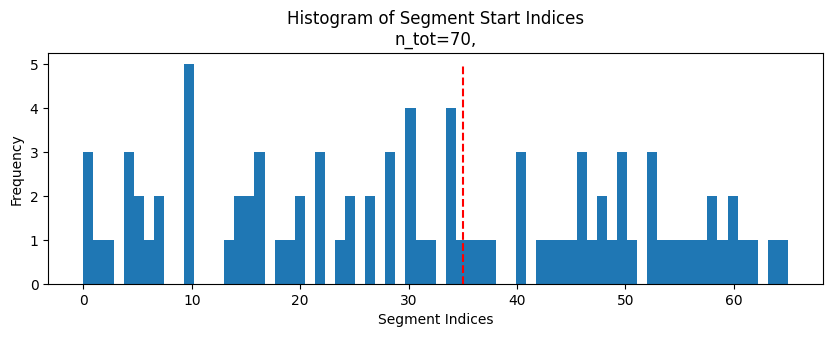

In [138]:
n_tot = 70
lmin = 5
lmax = n_tot // 3

sample = interupt_idx0(n_tot,
                       lmin=lmin,
                       lmax=lmax,
                       add_max=20,
                       verbose=True,
                       )

# filter out n_tot
sample = [s for s in sample if s < n_tot]

# histogram
plt.figure(figsize=(10, 3))
plt.hist(sample, bins=n_tot)
plt.vlines(n_tot//2, 0, 5, colors='r', linestyles='dashed')
plt.xlabel("Segment Indices")
plt.ylabel("Frequency")
plt.title(f"Histogram of Segment Start Indices\nn_tot={n_tot},")
plt.show()

shape.heatmap: (500, 500)


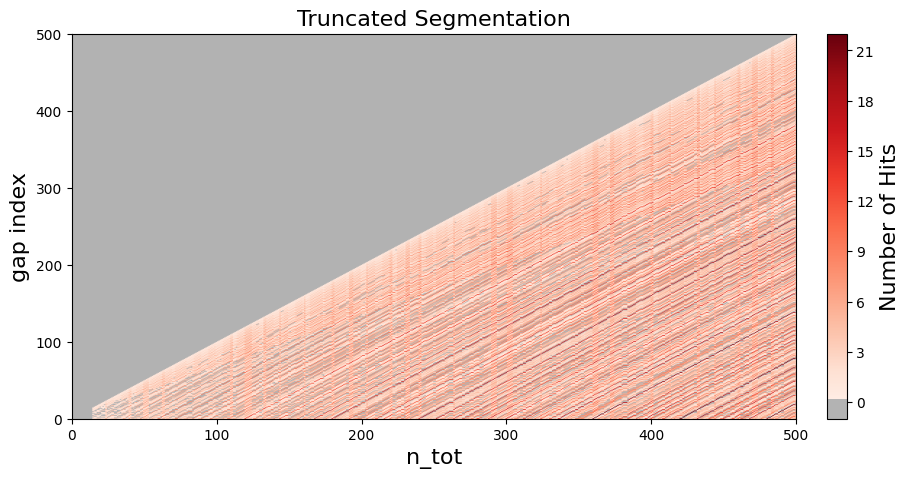

In [114]:
from matplotlib.colors import ListedColormap
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

lmin = 5
n_max = 500
n_arr = np.arange(lmin*3, n_max+1)

# Prepare the heatmap array
heatmap = np.full((n_max, n_max), -1)

print(f"shape.heatmap: {heatmap.shape}")
for i, n_tot in enumerate(n_arr):
    lmax = n_tot // 3
    heatmap[:n_tot, n_tot-1] += 1      # level from -1 to 0 to indicate that this combination is used

    sample = interupt_idx0(n_tot,
                           lmin=lmin,
                           lmax=lmax,
                           add_max=10,
                           #verbose=True,
                           )
    
    # filter out n_tot
    sample = [s for s in sample if s < n_tot]

    hist, _ = np.histogram(sample, bins=n_tot)

    heatmap[:n_tot, n_tot-1] += hist

cmap_reds = matplotlib.colormaps['Reds']
newcolors = cmap_reds(np.linspace(0, 1, 256))
grey = np.array([0.7, 0.7, 0.7, 1])

fig, axes = plt.subplots(1, 1, figsize=(10, 5), sharex=True)

# PLOT: ================================================================================

ix = 256//(heatmap.max()+1)
newcolors = np.copy(newcolors)
newcolors[:ix, :] = grey
cmap_custom = ListedColormap(newcolors)

im = axes.imshow(
    heatmap,
    aspect='auto',
    cmap=cmap_custom2,
    origin='lower',
    extent=[0, n_max, 0, n_max],
    vmin=-1, vmax=None,
)
#axes.plot(np.arange(n_max), np.arange(n_max)//2, color='grey', linestyle='--')
axes.set_xlabel('n_tot', fontsize=16)
axes.set_ylabel('gap index', fontsize=16)
axes.set_title(f'Truncated Segmentation', fontsize=16)

# Create a colorbar for the second heatmap
cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.025, pad=0.04)
cbar.set_label('Number of Hits', fontsize=16)
cbar.ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

plt.show()

## Sliding Window Segmentation

Jakob had the idear to use a sliding window to peform the segmentation.

In [50]:
import numpy as np

from toad.shifts.methods.asdetect_new import mad, median, polyfit


def construct_detection_ts(
    values_1d: np.ndarray,
    times_1d: np.ndarray,
    lmin: int,
    lmax: int = None,
    counter_plot: bool = False,
) -> np.ndarray:
    """
    """

    n_tot = len(values_1d)

    detection_ts = np.zeros_like(values_1d)

    # default to have at least three gradients (needed for grad distribution)
    if lmax is None:
        lmax = int(n_tot / 3)

    counter = np.zeros(n_tot)
    for length in range(lmin, lmax + 1):
        # Note: numba-compatible version of data splitting and 1st degree polyfit
        gradients = compute_gradients(values_1d, times_1d, length)

        # Note: numba-compatible versions of median absolute deviation (mad) and median
        grad_MAD = mad(gradients)  # median absolute deviation of the gradients
        grad_MEAN = median(gradients)  # median of the gradients

        # for each segment, check whether its gradient is larger than the
        # threshold. if yes, update the detection time series accordingly.
        # i1/i2 are the first/last index of a segment
        # - Create a mask for segments that exceed the threshold
        detection_mask = (
            np.abs(gradients - grad_MEAN) > 3 * grad_MAD
        )  # boolean mask; wether the gradient is significant
        sign_mask = np.sign(
            gradients - grad_MEAN
        )  # sign of the gradient (positive or negative)

        # Update detection time series
        for i1, shift_detected in enumerate(detection_mask):
            i2 = i1 + length
            counter[i1:i2] += 1
            if shift_detected:
                detection_ts[i1:i2] += sign_mask[i1]

    # normalize the detection time series to one
    normalization_factor = np.sum(np.arange(lmin, lmax + 1))
    detection_ts /= normalization_factor

    if counter_plot:
        import matplotlib.pyplot as plt

        plt.figure(figsize=(10, 3))
        plt.plot(counter, label='count')
        plt.hlines(normalization_factor, 0, n_tot, colors='coral', linestyles='dashed', label='normalization factor')
        plt.xlabel("Time Index")
        plt.ylabel("Count [absolute value]")
        plt.title(f"How many times a time index was part of a segment?\nlmin={lmin}, lmax={lmax}")
        plt.legend()
        plt.grid()
        plt.show()

    return detection_ts

def compute_gradients(
    values_1d: np.ndarray,
    times_1d: np.ndarray,
    length: int,
) -> np.ndarray:
    """
    """
    n_segs = len(values_1d) - length + 1 
    gradients = np.empty(n_segs)

    for i1 in range(n_segs):
        i2 = i1 + length
        tseg = times_1d[i1:i2]
        aseg = values_1d[i1:i2]
        gradients[i1] = polyfit(tseg, aseg, 1)[0]

    return gradients

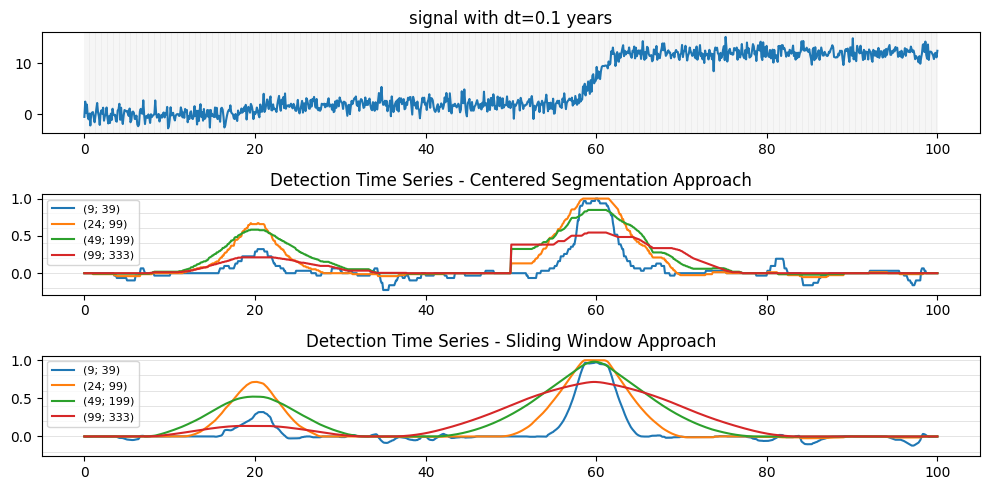

In [51]:
import numpy as np 
import matplotlib.pyplot as plt

from toad.shifts.methods.asdetect_new import ASDETECT as ASDETECT_new
from toad.shifts.methods.asdetect_new import centered_segmentation


def shift(mag, t, t0):
    return mag * (1/(1 + np.exp(-(t-t0))))

dt = 0.1
Tmax = 100 # years
nT = int(Tmax/dt) # number of gridpoints in time

# SIGNAL GENERATION =======================================================
noise = np.random.normal(size=nT)
time = np.linspace(0,Tmax, nT)

signal = (noise 
            + shift(10, time, 60)
            + shift(2,time,20)   
        )

# PLOT: SIGNAL ============================================================
fig = plt.figure(figsize=(10, 5))
gs = fig.add_gridspec(ncols=1, nrows=3)

ax1 = fig.add_subplot(gs[0, 0])

ax1.plot(time, signal)
for t in time:
    ax1.axvline(t, color='grey', alpha=0.1, lw=0.5, zorder=-1)

ax1.set_title(f'signal with dt={dt} years')


# PLOT: Centered Segmentation ==============================================
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
for lmin, lmax in [(9,39),(24,99),(49,199),(99,333)]:

    detector = ASDETECT_new(
        lmin=lmin,
        lmax=lmax,)
    dts = detector.fit_predict(
        signal,
        time,
        ufunc=centered_segmentation
        )

    ax2.plot(time, dts, label=f'({lmin}; {lmax})')
for val in [-0.2,0,0.2,0.4,0.6,0.8,1]:
    ax2.axhline(val, color='grey', alpha=0.3, lw=0.5, zorder=-1)
ax2.set_title('Detection Time Series - Centered Segmentation Approach')
ax2.legend(loc='upper left', fontsize=8)

# PLOT: Sliding Window ==============================================
ax3 = fig.add_subplot(gs[2, 0], sharex=ax1)
for lmin, lmax in [(9,39),(24,99),(49,199),(99,333)]:

    dts = construct_detection_ts(
        signal,
        time,
        lmin=lmin,
        lmax=lmax,
    )

    ax3.plot(time, dts, label=f'({lmin}; {lmax})')
for val in [-0.2,0,0.2,0.4,0.6,0.8,1]:
    ax3.axhline(val, color='grey', alpha=0.3, lw=0.5, zorder=-1)
ax3.set_title('Detection Time Series - Sliding Window Approach')
ax3.legend(loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()

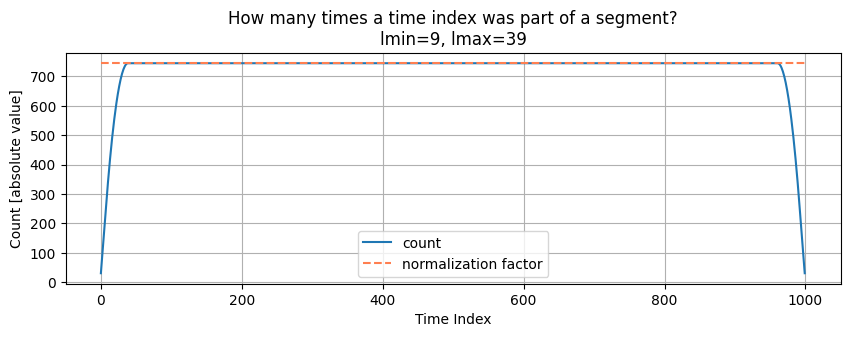

In [55]:
import numpy as np 
import matplotlib.pyplot as plt

from toad.shifts.methods.asdetect_new import ASDETECT as ASDETECT_new
from toad.shifts.methods.asdetect_new import centered_segmentation


def shift(mag, t, t0):
    return mag * (1/(1 + np.exp(-(t-t0))))

dt = 0.1
Tmax = 100 # years
nT = int(Tmax/dt) # number of gridpoints in time

# SIGNAL GENERATION =======================================================
noise = np.random.normal(size=nT)
time = np.linspace(0,Tmax, nT)

signal = (noise 
            + shift(10, time, 60)
            + shift(2,time,20)   
        )

# PLOT: COUNTER ============================================================
dts = construct_detection_ts(
    signal,
    time,
    lmin=9,
    lmax=39,
    counter_plot=True,
)